In [ ]:
!pip install fastai --upgrade
!pip install azure-cognitiveservices-search-imagesearch

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.0)
     |████████████████████████████████| 51kB 4.0MB/s 
     |████████████████████████████████| 92kB 7.8MB/s 
     |████████████████████████████████| 40kB 4.8MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 2.6MB 14.2MB/s 


In [ ]:
from fastai.vision.all import *
from utils import *
matplotlib.rc('image', cmap='Greys')

Good to start with a simple model. We have MNIST Sample that only has 3's and 7's.

`untar_data` takes a URL, checks if I have already downloaded (if not, downloads it), checks whether it is uncompressed and returns path.

In [ ]:
URLs.MNIST_SAMPLE

'http://files.fast.ai/data/examples/mnist_sample.tgz'

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path

Path('.')

In [ ]:
type(path)

pathlib.PosixPath

In [ ]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [ ]:
path.ls?

In [ ]:
doc(path.ls)

In [ ]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [ ]:
type(im3)

PIL.PngImagePlugin.PngImageFile

In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [ ]:
im3_t = tensor(im3)
#df = pd.DataFrame(im3_t[4:15, 4:22])
df = pd.DataFrame(im3_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0,0,0,0


How would I build a 3 vs. 7 detector? (Initial ideas)
* average pixel intensity of 3 should be greater than 7.
* see if there is a way to detect 2 lines (7)

Advice: always start with a reasonable baseline.

In [ ]:
# Let's generate a list of all of the sevens

sevens

(#6265) [Path('train/7/10002.png'),Path('train/7/1001.png'),Path('train/7/10014.png'),Path('train/7/10019.png'),Path('train/7/10039.png'),Path('train/7/10046.png'),Path('train/7/10050.png'),Path('train/7/10063.png'),Path('train/7/10077.png'),Path('train/7/10086.png')...]

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

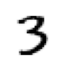

In [ ]:
# using fastai's `show_image` function to display a tensor image
show_image(three_tensors[1])

In [ ]:
# 28 x 28
three_tensors[1].shape

torch.Size([28, 28])

In [ ]:
type(three_tensors)

list

In [ ]:
# Turn list into a tensor

# When working with floats, we divide by 255. We normalize [0,1]
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

We have a rank-3 tensor with the first number (6131) being the number of images. We can get tensor rank by taking length of its shape

In [ ]:
len(stacked_threes.shape)

3

In [ ]:
stacked_threes.ndim

3

In [ ]:
# Returns a single number
# Average pixel values across the whole rank-3 tensor
stacked_threes.mean()

tensor(0.1415)

In [ ]:
# .mean(0) takes the mean over axis=0
stacked_threes.mean(0).shape

torch.Size([28, 28])

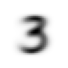

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

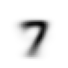

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

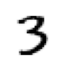

In [ ]:
# Now, let's just grab any 3
a_3 = stacked_threes[1]
show_image(a_3)

We can get differences between a number and mean number by (1) absolte difference or (2) root mean squared error

In [ ]:
abs_diff3 = abs(mean3 - a_3).mean()
print('{} is abs value of difference between 3 and mean 3'.format(abs_diff3))
rmse_diff3 = ((mean3 - a_3)**2).mean().sqrt()
print('{} is rmse between 3 and mean 3'.format(rmse_diff3))

0.1114361435174942 is abs value of difference between 3 and mean 3
0.20208261907100677 is rmse between 3 and mean 3


In [ ]:
print('{} is abs value of difference between 3 and mean 3'.format(
    abs(mean7 - a_3).mean()))

rmse_diff_mean7_3 = ((mean7 - a_3)**2).mean().sqrt()
print('{} is rmse between 3 and mean 7'.format(rmse_diff_mean7_3))

0.15861931443214417 is abs value of difference between 3 and mean 3
0.3021094799041748 is rmse between 3 and mean 7


In [ ]:
# PyTorch alternatives

F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

## Working with arrays and tensors

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array(data)
tns = tensor(data)

In [ ]:
arr #numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tns #pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
tns[1]

tensor([4, 5, 6])

In [ ]:
tns[:,1]

tensor([2, 5])

In [ ]:
tns[1,1:3]

tensor([5, 6])

In [ ]:
type(tns)

torch.Tensor

In [ ]:
tns.type()

'torch.LongTensor'

In [ ]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [ ]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing metrics using broadcasting

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                          for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                           for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [ ]:
def mnist_distance(a,b):
  return (a-b).abs().mean((-1, -2)) # mean over last and second-last dimensions

mnist_distance(a_3, mean3)

tensor(0.1114)

In [ ]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [ ]:
# Subtracts mean3 from valid_3_tens 1010 times
mean3.shape

torch.Size([28, 28])

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1316, 0.1153, 0.1353,  ..., 0.1356, 0.1180, 0.1479]),
 torch.Size([1010]))

In [ ]:
# element wise operation
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [ ]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [ ]:
def is_3(x):
  return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [ ]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [ ]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [ ]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

It is not obvious how we improve this model.

## SGD

In [ ]:
def f(x):
  return x**2

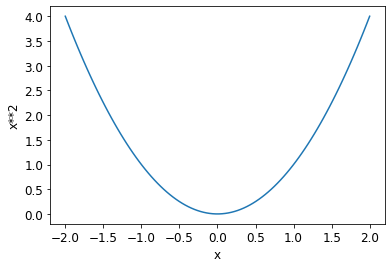

In [ ]:
plot_function(f, 'x', 'x**2')

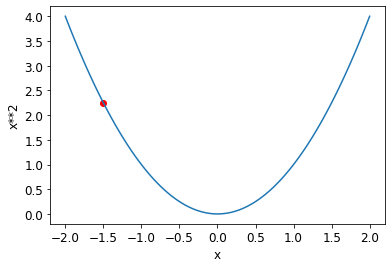

In [ ]:
# We start by picking a random value for a parameter and calculating
# the value of the loss
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [ ]:
# remember calculations taken so that we can calculate derivatives
xt = tensor(3.).requires_grad_()

In [ ]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [ ]:
# take the derivative
yt.backward()

In [ ]:
xt.grad

tensor(6.)

Let's repeat with a vector argument for our function

In [ ]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [ ]:
# Add `.sum()` to take vector and return a scalar
def f(x):
  return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [ ]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

## End-to-end gradient descent example

In [ ]:
time = torch.arange(0,20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

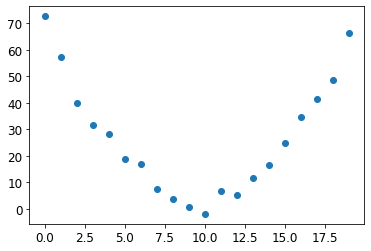

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)

In [ ]:
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

In [ ]:
def mse(preds, targets):
  return ((preds-targets)**2).mean()

In [ ]:
# initialize 3 random values
params = torch.randn(3).requires_grad_()

In [ ]:
# save for later
orig_params = params.clone()

In [ ]:
# Calculate predictions
preds = f(time, params)

In [ ]:
def show_preds(preds, ax=None):
  if ax is None:
    ax = plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300,100)

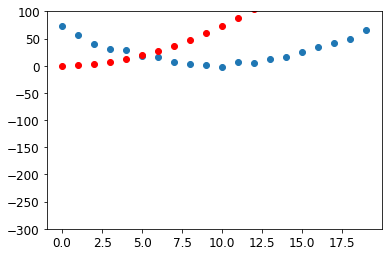

In [ ]:
show_preds(preds)

In [ ]:
loss = mse(preds, speed)
loss

tensor(10187.9268, grad_fn=<MeanBackward0>)

In [ ]:
# Calculate gradients

loss.backward()
params.grad

tensor([32728.7227,  2100.9204,   124.9925])

In [ ]:
lr = 1e-5

# .data means that the gradient is not calculated
# gradient should not be calculated for weight update step
params.data -= lr * params.grad.data

# Delete gradients we already had
params.grad = None

In [ ]:
preds = f(time,params)
mse(preds,speed)

tensor(2470.4707, grad_fn=<MeanBackward0>)

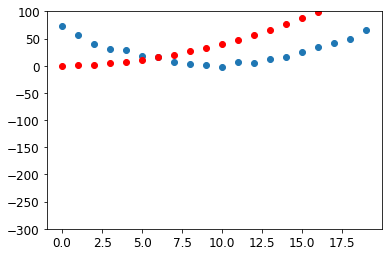

In [ ]:
show_preds(preds)

In [ ]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn:
    print(loss.item())
  return preds

In [ ]:
for i in range(10):
  apply_step(params)

2470.470703125
1010.0899658203125
733.7384643554688
681.4414672851562
671.5423583984375
669.6663208007812
669.3084106445312
669.23779296875
669.2215576171875
669.2156372070312


In [ ]:
params = orig_params.detach().requires_grad_()

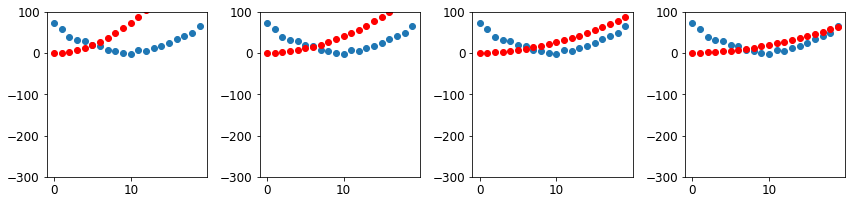

In [ ]:
_, axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs:
  show_preds(apply_step(params, False), ax)
plt.tight_layout()

## Questionnaire

How is a grayscale image represented on a computer? How about a color image? Grayscale image is represented as an array of numbers, from 0 to 255. Color image is represented as 3 images stacked together, with each image being an array of numbers.

How are the files and folders in the MNIST_SAMPLE dataset structured? Why? We have train and valid folders and within each of them sub-directories for '3' and '7'.

Explain how the "pixel similarity" approach to classifying digits works. We take the difference (absolute or RMSE) between an image and the "average image" for 3 or 7. Whichever average image has the smallest difference (or closest similarity) becomes the category for the image.

What is a list comprehension? Create one now that selects odd numbers from a list and doubles them. List comprehensions are easy ways to create lists from iterables with optional filters. Completed below.

What is a "rank-3 tensor"? Rank 3 tensor has 3 dimensions for the tensor shape.

What is the difference between tensor rank and shape? How do you get the rank from the shape? Tensor rank is the number of dimensions while the tensor shape gives us the length of each dimension. We can take the length of the shape to get the rank.

What are RMSE and L1 norm? RMSE is root mean squared error. It takes the squared difference between 2 tensors/vectors/arrays, adds up the differences, and takes square root of the result. L1 norm just takes the absolute difference and adds them up. 

How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop? Broadcasting.

Create a 3×3 tensor or array containing the numbers from 1 to 9. 
Double it. Select the bottom-right four numbers. Completed below

What is broadcasting? It is a way to extend tensor with smaller rank to have the same size as the one with the larger rank.

Are metrics generally calculated using the training set, or the validation set? Why? Metrics are calculated using the validation set. Metrics, like accuracy, may not change with smaller changes in the parameter values.

What is SGD? Gradient descent, as defined by Arthur Samuel, is a way of automatically assessing the performance of an ML model and updating the weight assignments.

Why does SGD use mini-batches? Instead of calculating loss over the entire data set or a single image, we take the middle path of calculating loss on mini-batches. It helps with balancing getting more accurate loss (from more images) with reducing time to compute loss (on GPU).

What are the seven steps in SGD for machine learning?
* Initialize weights
* Use weights to generate prediction
* Calculate loss
* Calculate gradient
* Step - update weights
* Repeat the process from step 2
* Iterate until I stop the training process

How do we initialize the weights in a model? We initialize the parameters to random values.

What is "loss"? It is a way to test how effective our current weight assignment is in terms of performance. The loss function returns a small number if the model performance is good, otherwise, it returns a larger number.

Why can't we always use a high learning rate? It can result in the loss getting worse or bouncing around with any convergence.

What is a "gradient"? It measures for each weight how changing that weight would change the loss. Note that in deep learning, gradient is the *value* of a function's derivative at a particular argument value, not another function.


In [1]:
# list comprehension problem
[i*2 for i in range(20) if i%2==1]

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38]

In [2]:
import torch

In [7]:
(torch.tensor([[1,2,3], [4,5,6], [7,8,9]]) * 2)[1:, 1:]

tensor([[10, 12],
        [16, 18]])